In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
drone_path = '../../../50m/*.wav'
background_path = '../../data/test_background/second-0-15:51:21.wav'

drone_files = glob.glob(drone_path)
background_files = glob.glob(background_path)

In [3]:
CHUNK_SIZE = 8192
SR = 22050
N_MFCC = 16

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
drone_raw = load(drone_files)
background_raw = load(background_files)

(2232320,)
(20480,)


In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
mfcc_drone, y_drone = mfcc4(drone_raw, 1)
mfcc_background, y_background = mfcc4(background_raw, 0)

print(mfcc_drone.shape, y_drone.shape)
print(mfcc_background.shape, y_background.shape)

(2232320,)
small end: (16, 9)
(20480,)
small end: (16, 9)
(544, 16, 16) (544,)
(4, 16, 16) (4,)


In [8]:
X = np.concatenate((mfcc_drone, mfcc_background), axis=0)
y = np.hstack((y_drone, y_background))
print(X.shape, y.shape)

(548, 16, 16) (548,)


In [9]:
n_labels = y.shape[0]
n_unique_labels = 2
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(548, 2)


In [10]:
X_train2 = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) 
print(X_train2.shape)

(548, 16, 16, 1)


In [11]:
n_mfcc = 16
n_frame = 16
n_classes = 2
n_channels = 1
learning_rate = 0.0002  ## 괜찮나용?

In [12]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels])
Y = tf.placeholder(tf.float32, shape=[None,n_classes])


conv1 = tf.layers.conv2d(inputs=X, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                padding="SAME", strides=1)
conv2 = tf.layers.conv2d(inputs=pool1, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                padding="SAME", strides=1)

flat = tf.reshape(pool2, [-1, 16*16*1])

dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=dense2, units=2)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [13]:
sess = tf.Session()
saver = tf.train.Saver()
# 모델 불러오는 path
saver.restore(sess, '../../model/CNN/cnn_model')

INFO:tensorflow:Restoring parameters from ../../model/CNN/cnn_model


In [14]:
# Prediction
y_test = sess.run(tf.nn.softmax(logits), feed_dict={X:X_train2})
y_pred = sess.run(tf.argmax(logits,1), feed_dict={X:X_train2})
y_true = sess.run(tf.argmax(y_encoded,1))

import pandas as pd
pd.options.display.max_rows = 4000
print(pd.DataFrame(y_test))

                0             1
0    5.394952e-01  4.605048e-01
1    2.456792e-01  7.543207e-01
2    9.999005e-01  9.955292e-05
3    4.630812e-04  9.995370e-01
4    2.367621e-04  9.997632e-01
5    3.859214e-01  6.140786e-01
6    6.584586e-04  9.993415e-01
7    7.009511e-06  9.999930e-01
8    3.542241e-10  1.000000e+00
9    1.148250e-05  9.999886e-01
10   3.590736e-02  9.640927e-01
11   1.764289e-10  1.000000e+00
12   4.499954e-07  9.999995e-01
13   7.639740e-11  1.000000e+00
14   9.892608e-01  1.073923e-02
15   1.261188e-01  8.738812e-01
16   5.497491e-02  9.450251e-01
17   9.749364e-01  2.506357e-02
18   3.303911e-01  6.696088e-01
19   7.966123e-10  1.000000e+00
20   4.810259e-07  9.999995e-01
21   2.220890e-05  9.999778e-01
22   6.313004e-02  9.368700e-01
23   7.277436e-02  9.272256e-01
24   6.852210e-01  3.147790e-01
25   5.821950e-02  9.417804e-01
26   9.615190e-01  3.848103e-02
27   5.334942e-08  1.000000e+00
28   1.080387e-09  1.000000e+00
29   4.417038e-01  5.582963e-01
30   2.0

In [15]:
sum = 0
for i in range(0, len(y_test)-4):
    sum = sum + y_test[i][1]
print(sum, sum/(len(y_test)-4))

433.5846322599311 0.7970305740072262


F-Score: 0.805
Accuracy:  0.8047445255474452
              precision    recall  f1-score   support

           0       0.04      1.00      0.07         4
           1       1.00      0.80      0.89       544

   micro avg       0.80      0.80      0.80       548
   macro avg       0.52      0.90      0.48       548
weighted avg       0.99      0.80      0.88       548

[[  4   0]
 [107 437]]


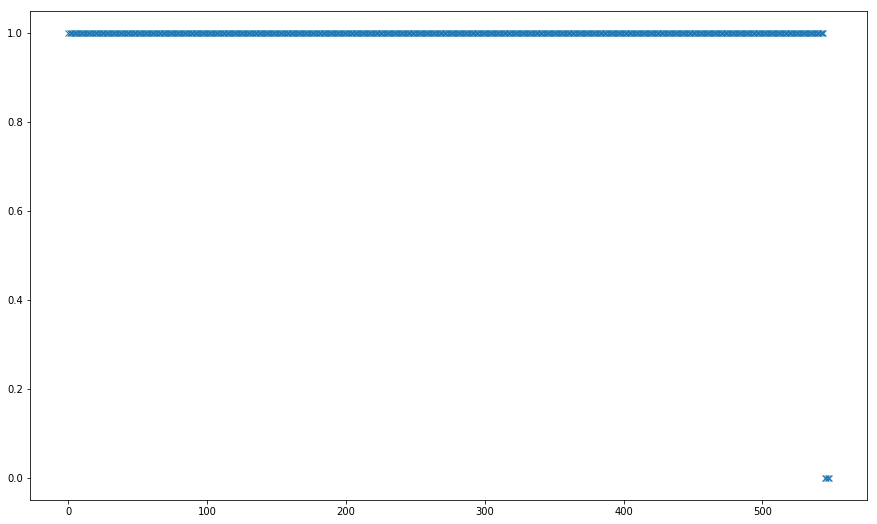

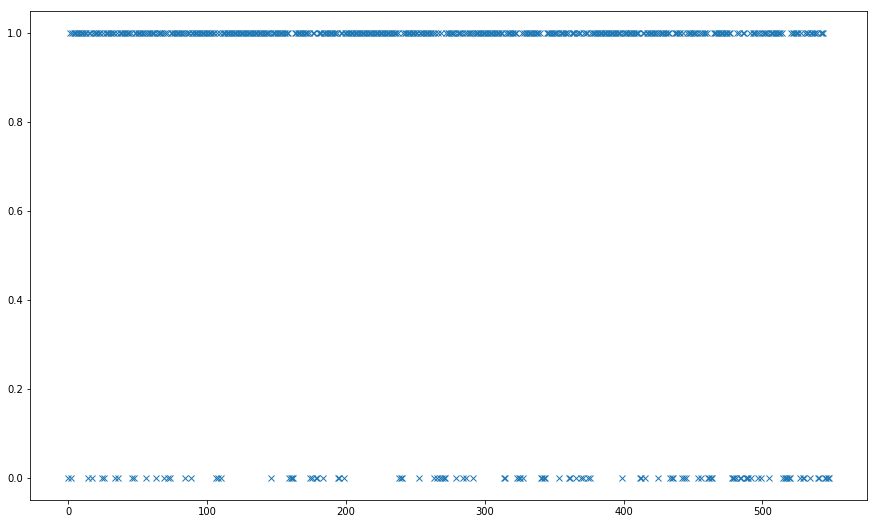

In [16]:
# Print Result
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true, 'x')

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred, 'x')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))